In [1]:
from mne import Epochs, find_events, set_eeg_reference, read_epochs, viz, combine_evoked
from time import time, strftime, gmtime
from collections import OrderedDict
from glob import glob
from collections import OrderedDict
from mne import create_info, concatenate_raws
from mne.io import RawArray
from mne.channels import read_montage
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'app','utils','jupyter'))
import utils
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
files = ['C:/Users/jdpig/BrainWaves Workspaces/N170 Validate/Data/Subash/EEG/Subash-1-raw.csv']
replace_ch_names = None
raw = utils.load_data(files)

['C:/Users/jdpig/BrainWaves Workspaces/N170 Validate/Data/Subash/EEG/Subash-1-raw.csv']
Creating RawArray with float64 data, n_channels=15, n_times=19885
    Range : 0 ... 19884 =      0.000 ...   155.344 secs
Ready.


In [3]:
## Filtering Data

# Input
low_cutoff = 1
high_cutoff = 30

# Computation
raw.filter(low_cutoff, high_cutoff, method='iir');

Setting up band-pass filter from 1 - 30 Hz


Effective window size : 16.000 (s)


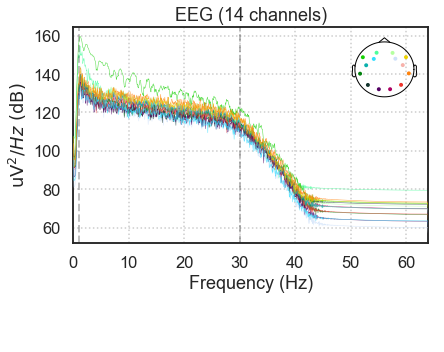

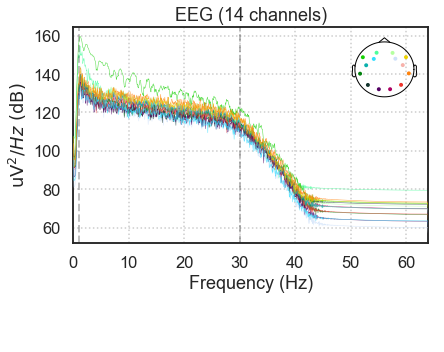

In [4]:
raw.plot_psd()

In [5]:
## Epoch Data

# Input
event_id = {'House': 1, 'Face': 2}
tmin=-0.1
tmax=0.8
baseline = (tmin, tmax)
picks = None
reject = None

# Computation
events = find_events(raw)
# TODO: Figure out how to normalize and auto-reject Emotiv EEG data
epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=tmin, tmax=tmax, baseline=baseline, reject=reject, preload=True, 
                verbose=False, picks=picks)

# Output
{"totalEpochs": len(epochs.events), "dropPercentage": (1 - len(epochs.events)/len(events)) * 100, **{x: len(epochs[x]) for x in event_id}}

100 events found
Event IDs: [1 2]


{'Face': 55, 'House': 45, 'dropPercentage': 0.0, 'totalEpochs': 100}

In [9]:
%matplotlib
epoch_editor = epochs.plot(scalings='auto', n_epochs=8, title="", events=None);


Using matplotlib backend: Qt5Agg
Channels marked as bad: []


In [66]:
epochs.save('C:/Users/jdpig/BrainWaves Workspaces/Dano Nelson Faces Houses/data/Test/EEG/Test_1-epo.fif')

In [21]:
%matplotlib
clean_epochs_plot = epochs.plot(scalings='auto');
fig = plt.gcf()
fig.canvas.manager.window.activateWindow()
fig.canvas.manager.window.raise_()

Channels marked as bad: []
Using matplotlib backend: Qt5Agg


AttributeError: Unknown property ymargin

Channels marked as bad: []


In [ ]:
## Plot ERPs

# Input
ch_ind = 10

# Computation
conditions = OrderedDict({key: [value] for (key, value) in event_id.items()})

# Output
X, y = utils.plot_conditions(epochs, ch_ind=ch_ind, conditions=conditions, 
                                ci=97.5, n_boot=1000, title='',)

In [ ]:
{'House': 3, 'Face': 4}.items()